<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 5: ASHRAE - Great Energy Predictor III (Part 3b Modeling GRU)

 - [Modeling](#Modeling)
 - [Models Ensembling](#Models-Ensembling)
 - [Significant Findings and Recommendations](#Significant-Findings-and-Recommendations)

## Modeling

### Importing Libraries

In [1]:
import pandas as pd
pd.reset_option('^display.', silent=True)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import boto3
import joblib
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping
from lofo import LOFOImportance, Dataset, plot_importance
from keras import backend as K
from keras.models import load_model

2022-05-05 01:31:02.936866: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-05 01:31:02.936906: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/ubuntu/.local/lib/python3.10/site-packages/lofo/lofo_importance.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# !pip install pandas
# !pip install seaborn
# !pip install matplotlib
# !pip install xgboost
# !pip install lofo-importance
# !pip install imblearn
# !pip install smart_open
# !pip install boto3
# !pip install s3fs

In [3]:
s3 = boto3.resource(
    service_name = 's3',
    region_name = 'us-east-1',
    aws_access_key_id = '', #key hidden due to privacy reason 
    aws_secret_access_key = ''#key hidden due to privacy reason 
    
)

In [4]:
import os
os.environ["AWS_DEFAULT_REGION"] = 'us-east-1'
os.environ['AWS_ACCESS_KEY_ID'] = '' #key hidden due to privacy reason 
os.environ['AWS_SECRET_ACCESS_KEY'] = '' #key hidden due to privacy reason 

In [6]:
obj = s3.Bucket('jiashengs3').Object('cleaned_train3.csv').get()
obj1 = s3.Bucket('jiashengs3').Object('cleaned_test3.csv').get()

In [7]:
# retriving cleaned train and test datasets from s3 bucket
train_df = pd.read_csv(obj['Body'],index_col=0)
test_df = pd.read_csv(obj1['Body'],index_col=0)

In [8]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [9]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 4506.58 MB
Memory usage after optimization is: 1239.31 MB
Decreased by 72.5%
Memory usage of dataframe is 9225.70 MB
Memory usage after optimization is: 2465.49 MB
Decreased by 73.3%


In [10]:
train_df = train_df.reset_index()
test_df = test_df.reset_index()

In [11]:
#Splitting into the 4 different meter types
train_df_0 = train_df[train_df['meter']==0]
train_df_1 = train_df[train_df['meter']==1]
train_df_2 = train_df[train_df['meter']==2]
train_df_3 = train_df[train_df['meter']==3]

In [12]:
#Splitting into the 4 different meter types
test_df_0 = test_df[test_df['meter']==0]
test_df_1 = test_df[test_df['meter']==1]
test_df_2 = test_df[test_df['meter']==2]
test_df_3 = test_df[test_df['meter']==3]

In [13]:
#Previously from 3a, consolidated good features for each meter type as follows:
goodfeatures0 = ['square_feet',
                 'building_id',
                 'primary_use',
                 'bcps',
                 'bcpf',
                 'Wind_chill(degC)_mean_lag3',
                 'cloud_coverage_1',
                 'site_id',
                 'dew_temperature_1_mean_lag3',
                 'sea_level_pressure_1',
                 'feels_like(degC)',
                 'wind_direction_1',
                 'precip_depth_1_hr_1',
                 'Heat_index(degC)',
                 'month',
                 'dew_temperature_1',
                 'season',
                 'air_temperature_1_mean_lag3',
                 'wind_speed_1']

goodfeatures1 = ['square_feet',
                 'building_id',
                 'air_temperature_1',
                 'dew_temperature_1',
                 'RH%',
                 'precip_depth_1_hr_1',
                 'air_temperature_1_mean_lag3',
                 'cloud_coverage_1',
                 'Wind_chill(degC)',
                 'dew_temperature_1_mean_lag3',
                 'Heat_index(degC)_mean_lag3',
                 'wind_speed_1',
                 'Heat_index(degC)',
                 'sea_level_pressure_1',
                 'bcpf',
                 'feels_like(degC)_mean_lag3',
                 'season',
                 'site_id',
                 'Wind_chill(degC)_mean_lag3',
                 'wind_direction_1',
                 'month',
                 'primary_use']

goodfeatures2 = ['square_feet',
                 'building_id',
                 'bcps',
                 'primary_use',
                 'month',
                 'season',
                 'feels_like(degC)',
                 'cloud_coverage_1',
                 'Wind_chill(degC)_mean_lag3',
                 'air_temperature_1',
                 'site_id']

goodfeatures3 = ['building_id',
                 'square_feet',
                 'primary_use',
                 'dew_temperature_1',
                 'air_temperature_1',
                 'Wind_chill(degC)_mean_lag3',
                 'feels_like(degC)',
                 'wind_speed_1',
                 'month',
                 'season',
                 'site_id',
                 'sea_level_pressure_1']

#### Get dummies for categorical features of meter 0

In [14]:
categorical_features_meter0 = ['primary_use', 'season', 'month']

In [15]:
train_meter_0 = train_df_0.sort_values(by=['building_id', 'month', 'day', 'hour']).reset_index(drop=True)

In [16]:
train_m0 = train_meter_0[goodfeatures0].reset_index(drop=True)

In [17]:
train_gru_m0 = pd.get_dummies(data=train_m0, columns=categorical_features_meter0, drop_first=True)

#### Train-Test Split for Meter 0

In [18]:
X_train, X_test, y_train, y_test = train_test_split(train_gru_m0,train_meter_0['log_meter_reading'],test_size=0.3,shuffle=False)

### Scaling

In [19]:
mm = MinMaxScaler()
X_train_mm = mm.fit_transform(X_train)

In [20]:
X_test_mm = mm.transform(X_test)

#### TimeSeriesGenerator

In [21]:
train_sequences_meter0 = TimeseriesGenerator(X_train_mm, y_train.values, length=6, batch_size=1024)

In [22]:
#batch_x, batch_y = train_sequences_meter0[0]

In [23]:
test_sequences_meter0 = TimeseriesGenerator(X_test_mm, y_test.values, length=6, batch_size=1024)

### GRU Model Training for Meter 0

- We will have 2 GRU Layers
- 2 hidden dense layers
- 1 dense output layer

In [25]:
input_shape = train_sequences_meter0[0][0][0].shape

In [51]:
model = Sequential()
model.add(GRU(64 , input_shape=input_shape, return_sequences=True)) # True if next layer is RNN
model.add(GRU(32, return_sequences=False)) # False if next layer is Dense
model.add(Dropout(0.5))
model.add(Dense(16, activation='LeakyReLU'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='LeakyReLU'))
model.add(Dense(1, activation='linear'))
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0, 
                           patience=5, 
                           mode='auto')

In [35]:
#Custom function to derive rmse for keras as loss function
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [54]:
model.compile(optimizer=Adam(lr=.001), loss=root_mean_squared_error)
history = model.fit(train_sequences_meter0, validation_data=test_sequences_meter0, epochs=15, batch_size = 1024, callbacks = [early_stop])

Epoch 1/15


/home/ubuntu/.local/lib/python3.10/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


7932/7932 [==============================] - 299s 37ms/step - loss: 1.1429 - val_loss: 0.8951
Epoch 2/15
7932/7932 [==============================] - 296s 37ms/step - loss: 0.9406 - val_loss: 1.0838
Epoch 3/15
7932/7932 [==============================] - 296s 37ms/step - loss: 0.8955 - val_loss: 0.9060
Epoch 4/15
7932/7932 [==============================] - 296s 37ms/step - loss: 0.8700 - val_loss: 0.8538
Epoch 5/15
7932/7932 [==============================] - 296s 37ms/step - loss: 0.8527 - val_loss: 0.8218
Epoch 6/15
7932/7932 [==============================] - 296s 37ms/step - loss: 0.8384 - val_loss: 0.8556
Epoch 7/15
7932/7932 [==============================] - 296s 37ms/step - loss: 0.8251 - val_loss: 0.8520
Epoch 8/15
7932/7932 [==============================] - 297s 37ms/step - loss: 0.8154 - val_loss: 0.8275
Epoch 9/15
7932/7932 [==============================] - 296s 37ms/step - loss: 0.8034 - val_loss: 0.8254
Epoch 10/15
7932/7932 [==============================] - 297s 37ms

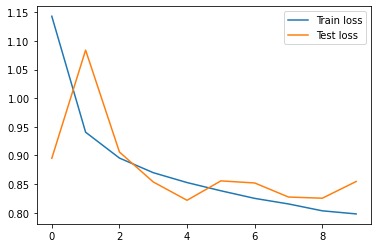

In [56]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.legend();

In [57]:
model.save("GRU_model_meter0.h5")
print("Model is saved")

Model is saved


#### Meter type 0 prediction

In [27]:
submission_meter_0 = test_df_0.sort_values(by=['building_id', 'month', 'day', 'hour']).reset_index(drop=True)

In [28]:
submission_m0 = submission_meter_0[goodfeatures0].reset_index(drop=True)

In [29]:
submission_gru_m0 = pd.get_dummies(data=submission_m0, columns=categorical_features_meter0, drop_first=True)

In [30]:
submission_gru_m0_mm = mm.transform(submission_gru_m0)

In [33]:
submission_m0_generator = TimeseriesGenerator(submission_gru_m0_mm, np.zeros(len(submission_gru_m0_mm)), length=6, batch_size=1024)
print(submission_m0_generator[0][0].shape)

(1024, 6, 45)


In [36]:
model0 = load_model('GRU_model_meter0.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error})

2022-05-04 14:55:31.056512: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-04 14:55:31.056555: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-04 14:55:31.056577: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-10-0-1-206): /proc/driver/nvidia/version does not exist
2022-05-04 14:55:31.058523: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [38]:
model0.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 6, 64)             21312     
                                                                 
 gru_3 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 1)                

In [44]:
meter0_predicted = np.expm1(model0.predict(submission_m0_generator))

In [78]:
meter0_ravel = meter0_predicted.ravel()

In [85]:
#to fill in the missing 6 observations with 0
meter0_ravel = np.insert(meter0_ravel, [0,0,0,0,0,0], [0,0,0,0,0,0], axis=0)  

In [91]:
submission_meter_0['meter_reading'] = meter0_ravel

In [95]:
submission_meter_0 = submission_meter_0[['row_id','meter_reading']].sort_values(by='row_id').reset_index(drop=True)

/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='meter_reading', ylabel='Density'>

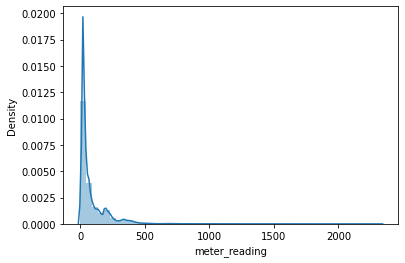

In [97]:
sns.distplot(submission_meter_0['meter_reading'])

#### Meter 1

Performing the same steps as above to train GRU model for meter 1

In [106]:
goodfeatures1

['square_feet',
 'building_id',
 'air_temperature_1',
 'dew_temperature_1',
 'RH%',
 'precip_depth_1_hr_1',
 'air_temperature_1_mean_lag3',
 'cloud_coverage_1',
 'Wind_chill(degC)',
 'dew_temperature_1_mean_lag3',
 'Heat_index(degC)_mean_lag3',
 'wind_speed_1',
 'Heat_index(degC)',
 'sea_level_pressure_1',
 'bcpf',
 'feels_like(degC)_mean_lag3',
 'season',
 'site_id',
 'Wind_chill(degC)_mean_lag3',
 'wind_direction_1',
 'month',
 'primary_use']

In [107]:
categorical_features_meter1 = ['primary_use', 'season', 'month']
train_meter_1 = train_df_1.sort_values(by=['building_id', 'month', 'day', 'hour']).reset_index(drop=True)
train_m1 = train_meter_1[goodfeatures1].reset_index(drop=True)
train_gru_m1 = pd.get_dummies(data=train_m1, columns=categorical_features_meter1, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(train_gru_m1,train_meter_1['log_meter_reading'],test_size=0.3,shuffle=False)

In [108]:
mm = MinMaxScaler()
X_train1_mm = mm.fit_transform(X_train)

In [109]:
X_test1_mm = mm.transform(X_test)

In [113]:
train_sequences_meter1 = TimeseriesGenerator(X_train1_mm, y_train.values, length=6, batch_size=1024)
test_sequences_meter1 = TimeseriesGenerator(X_test1_mm, y_test.values, length=6, batch_size=1024)

In [114]:
input_shape = train_sequences_meter1[0][0][0].shape

In [116]:
model1 = Sequential()
model1.add(GRU(64 , input_shape=input_shape, return_sequences=True)) # True if next layer is RNN
model1.add(GRU(32, return_sequences=False)) # False if next layer is Dense
model1.add(Dense(16, activation='LeakyReLU'))
model1.add(Dropout(0.5))
model1.add(Dense(8, activation='LeakyReLU'))
model1.add(Dropout(0.5))
model1.add(Dense(1, activation='linear'))
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0, 
                           patience=5, 
                           mode='auto')

In [118]:
model1.compile(optimizer=Adam(lr=.001), loss=root_mean_squared_error)
history1 = model1.fit(train_sequences_meter1, validation_data=test_sequences_meter1, epochs=15, batch_size = 1024, callbacks = [early_stop])

Epoch 1/15
2840/2840 [==============================] - 109s 37ms/step - loss: 2.5291 - val_loss: 2.3365
Epoch 2/15
2840/2840 [==============================] - 105s 37ms/step - loss: 2.1531 - val_loss: 2.2466
Epoch 3/15
2840/2840 [==============================] - 105s 37ms/step - loss: 1.9893 - val_loss: 2.2164
Epoch 4/15
2840/2840 [==============================] - 105s 37ms/step - loss: 1.8978 - val_loss: 2.2769
Epoch 5/15
2840/2840 [==============================] - 105s 37ms/step - loss: 1.8373 - val_loss: 2.2210
Epoch 6/15
2840/2840 [==============================] - 105s 37ms/step - loss: 1.8036 - val_loss: 2.2127
Epoch 7/15
2840/2840 [==============================] - 105s 37ms/step - loss: 1.7683 - val_loss: 2.2461
Epoch 8/15
2840/2840 [==============================] - 105s 37ms/step - loss: 1.7521 - val_loss: 2.2028
Epoch 9/15
2840/2840 [==============================] - 105s 37ms/step - loss: 1.7279 - val_loss: 2.2068
Epoch 10/15
2840/2840 [==============================] 

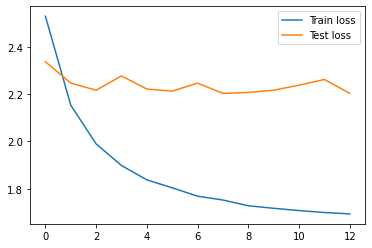

In [119]:
plt.plot(history1.history['loss'], label='Train loss')
plt.plot(history1.history['val_loss'], label='Test loss')
plt.legend();

In [121]:
model1.save("GRU_model_meter1.h5")
print("Model1 is saved")

Model1 is saved


#### Prediction for Meter 1

In [122]:
submission_meter_1 = test_df_1.sort_values(by=['building_id', 'month', 'day', 'hour']).reset_index(drop=True)
submission_m1 = submission_meter_1[goodfeatures1].reset_index(drop=True)
submission_gru_m1 = pd.get_dummies(data=submission_m1, columns=categorical_features_meter1, drop_first=True)
submission_gru_m1_mm = mm.transform(submission_gru_m1)

In [126]:
submission_m1_generator = TimeseriesGenerator(submission_gru_m1_mm, np.zeros(len(submission_gru_m1_mm)), length=6, batch_size=1024)
print(submission_m1_generator[0][0].shape)

(1024, 6, 48)


In [127]:
meter1_predicted = np.expm1(model1.predict(submission_m1_generator))
meter1_ravel = meter1_predicted.ravel()

#to fill in the missing 6 observations with 0
meter1_ravel = np.insert(meter1_ravel, [0,0,0,0,0,0], [0,0,0,0,0,0], axis=0)  

In [128]:
submission_meter_1['meter_reading'] = meter1_ravel

/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='meter_reading', ylabel='Density'>

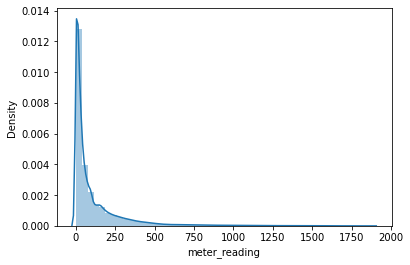

In [129]:
sns.distplot(submission_meter_1['meter_reading'])

#### Meter 2

Training GRU model for meter 2

In [130]:
goodfeatures2

['square_feet',
 'building_id',
 'bcps',
 'primary_use',
 'month',
 'season',
 'feels_like(degC)',
 'cloud_coverage_1',
 'Wind_chill(degC)_mean_lag3',
 'air_temperature_1',
 'site_id']

In [132]:
categorical_features_meter2 = ['primary_use', 'season', 'month']
train_meter_2 = train_df_2.sort_values(by=['building_id', 'month', 'day', 'hour']).reset_index(drop=True)
train_m2 = train_meter_2[goodfeatures2].reset_index(drop=True)
train_gru_m2 = pd.get_dummies(data=train_m2, columns=categorical_features_meter2, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(train_gru_m2,train_meter_2['log_meter_reading'],test_size=0.3,shuffle=False)

In [133]:
mm = MinMaxScaler()
X_train2_mm = mm.fit_transform(X_train)

In [134]:
X_test2_mm = mm.transform(X_test)

In [136]:
train_sequences_meter2 = TimeseriesGenerator(X_train2_mm, y_train.values, length=6, batch_size=1024)
test_sequences_meter2 = TimeseriesGenerator(X_test2_mm, y_test.values, length=6, batch_size=1024)

In [137]:
input_shape = train_sequences_meter2[0][0][0].shape

In [138]:
model2 = Sequential()
model2.add(GRU(64 , input_shape=input_shape, return_sequences=True)) # True if next layer is RNN
model2.add(GRU(32, return_sequences=False)) # False if next layer is Dense
model2.add(Dropout(0.5))
model2.add(Dense(16, activation='LeakyReLU'))
model2.add(Dropout(0.5))
model2.add(Dense(8, activation='LeakyReLU'))
model2.add(Dense(1, activation='linear'))
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0, 
                           patience=5, 
                           mode='auto')

In [139]:
model2.compile(optimizer=Adam(lr=.001), loss=root_mean_squared_error)
history2 = model2.fit(train_sequences_meter2, validation_data=test_sequences_meter2, epochs=15, batch_size = 1024, callbacks = [early_stop])

Epoch 1/15


/home/ubuntu/.local/lib/python3.10/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1836/1836 [==============================] - 72s 38ms/step - loss: 2.5988 - val_loss: 2.0193
Epoch 2/15
1836/1836 [==============================] - 68s 37ms/step - loss: 2.1851 - val_loss: 1.6728
Epoch 3/15
1836/1836 [==============================] - 68s 37ms/step - loss: 2.0196 - val_loss: 1.7823
Epoch 4/15
1836/1836 [==============================] - 68s 37ms/step - loss: 1.9550 - val_loss: 1.6652
Epoch 5/15
1836/1836 [==============================] - 68s 37ms/step - loss: 1.9190 - val_loss: 1.7012
Epoch 6/15
1836/1836 [==============================] - 68s 37ms/step - loss: 1.8915 - val_loss: 1.7013
Epoch 7/15
1836/1836 [==============================] - 68s 37ms/step - loss: 1.8676 - val_loss: 1.6576
Epoch 8/15
1836/1836 [==============================] - 68s 37ms/step - loss: 1.8499 - val_loss: 1.6770
Epoch 9/15
1836/1836 [==============================] - 68s 37ms/step - loss: 1.8377 - val_loss: 1.6810
Epoch 10/15
1836/1836 [==============================] - 68s 37ms/step - lo

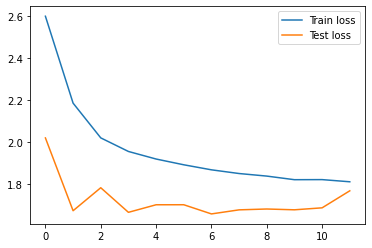

In [140]:
plt.plot(history2.history['loss'], label='Train loss')
plt.plot(history2.history['val_loss'], label='Test loss')
plt.legend();

In [141]:
model2.save("GRU_model_meter2.h5")
print("Model2 is saved")

Model2 is saved


#### Prediction for Meter 2

In [142]:
submission_meter_2 = test_df_2.sort_values(by=['building_id', 'month', 'day', 'hour']).reset_index(drop=True)
submission_m2 = submission_meter_2[goodfeatures2].reset_index(drop=True)
submission_gru_m2 = pd.get_dummies(data=submission_m2, columns=categorical_features_meter2, drop_first=True)
submission_gru_m2_mm = mm.transform(submission_gru_m2)

In [143]:
submission_m2_generator = TimeseriesGenerator(submission_gru_m2_mm, np.zeros(len(submission_gru_m2_mm)), length=6, batch_size=1024)
print(submission_m2_generator[0][0].shape)

(1024, 6, 37)


In [145]:
meter2_predicted = np.expm1(model2.predict(submission_m2_generator))
meter2_ravel = meter2_predicted.ravel()

#to fill in the missing 6 observations with 0
meter2_ravel = np.insert(meter2_ravel, [0,0,0,0,0,0], [0,0,0,0,0,0], axis=0)  

In [146]:
submission_meter_2['meter_reading'] = meter2_ravel

/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='meter_reading', ylabel='Density'>

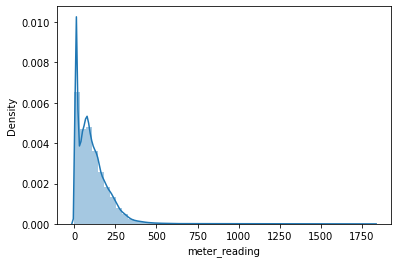

In [147]:
sns.distplot(submission_meter_2['meter_reading'])

#### Meter 3

Training GRU model for meter 3

In [148]:
goodfeatures3

['building_id',
 'square_feet',
 'primary_use',
 'dew_temperature_1',
 'air_temperature_1',
 'Wind_chill(degC)_mean_lag3',
 'feels_like(degC)',
 'wind_speed_1',
 'month',
 'season',
 'site_id',
 'sea_level_pressure_1']

In [149]:
categorical_features_meter3 = ['primary_use', 'season', 'month']
train_meter_3 = train_df_3.sort_values(by=['building_id', 'month', 'day', 'hour']).reset_index(drop=True)
train_m3 = train_meter_3[goodfeatures3].reset_index(drop=True)
train_gru_m3 = pd.get_dummies(data=train_m3, columns=categorical_features_meter3, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(train_gru_m3,train_meter_3['log_meter_reading'],test_size=0.3,shuffle=False)

In [150]:
mm = MinMaxScaler()
X_train3_mm = mm.fit_transform(X_train)

In [151]:
X_test3_mm = mm.transform(X_test)

In [152]:
train_sequences_meter3 = TimeseriesGenerator(X_train3_mm, y_train.values, length=6, batch_size=1024)
test_sequences_meter3 = TimeseriesGenerator(X_test3_mm, y_test.values, length=6, batch_size=1024)

In [153]:
input_shape = train_sequences_meter3[0][0][0].shape

In [154]:
input_shape

(6, 38)

In [155]:
model3 = Sequential()
model3.add(GRU(64 , input_shape=input_shape, return_sequences=True)) # True if next layer is RNN
model3.add(GRU(32, return_sequences=False)) # False if next layer is Dense
model3.add(Dropout(0.5))
model3.add(Dense(16, activation='LeakyReLU'))
model3.add(Dropout(0.5))
model3.add(Dense(8, activation='LeakyReLU'))
model3.add(Dense(1, activation='linear'))
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0, 
                           patience=5, 
                           mode='auto')

In [156]:
model3.compile(optimizer=Adam(lr=.001), loss=root_mean_squared_error)
history3 = model3.fit(train_sequences_meter3, validation_data=test_sequences_meter3, epochs=15, batch_size = 1024, callbacks = [early_stop])

Epoch 1/15


/home/ubuntu/.local/lib/python3.10/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


854/854 [==============================] - 36s 38ms/step - loss: 2.2460 - val_loss: 2.5156
Epoch 2/15
854/854 [==============================] - 32s 37ms/step - loss: 2.0785 - val_loss: 2.3206
Epoch 3/15
854/854 [==============================] - 32s 37ms/step - loss: 2.0107 - val_loss: 2.6040
Epoch 4/15
854/854 [==============================] - 32s 37ms/step - loss: 1.9611 - val_loss: 2.3467
Epoch 5/15
854/854 [==============================] - 32s 37ms/step - loss: 1.9419 - val_loss: 2.2676
Epoch 6/15
854/854 [==============================] - 32s 37ms/step - loss: 1.8976 - val_loss: 2.3559
Epoch 7/15
854/854 [==============================] - 32s 37ms/step - loss: 1.8489 - val_loss: 2.3767
Epoch 8/15
854/854 [==============================] - 32s 37ms/step - loss: 1.8407 - val_loss: 2.2998
Epoch 9/15
854/854 [==============================] - 32s 37ms/step - loss: 1.8268 - val_loss: 2.4642
Epoch 10/15
854/854 [==============================] - 32s 37ms/step - loss: 1.8089 - val_los

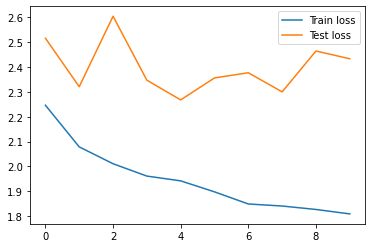

In [157]:
plt.plot(history3.history['loss'], label='Train loss')
plt.plot(history3.history['val_loss'], label='Test loss')
plt.legend();

In [158]:
model3.save("GRU_model_meter3.h5")
print("Model3 is saved")

Model3 is saved


#### Prediction for Meter 3


In [159]:
submission_meter_3 = test_df_3.sort_values(by=['building_id', 'month', 'day', 'hour']).reset_index(drop=True)
submission_m3 = submission_meter_3[goodfeatures3].reset_index(drop=True)
submission_gru_m3 = pd.get_dummies(data=submission_m3, columns=categorical_features_meter3, drop_first=True)
submission_gru_m3_mm = mm.transform(submission_gru_m3)

In [160]:
submission_m3_generator = TimeseriesGenerator(submission_gru_m3_mm, np.zeros(len(submission_gru_m3_mm)), length=6, batch_size=1024)
print(submission_m3_generator[0][0].shape)

(1024, 6, 38)


In [161]:
meter3_predicted = np.expm1(model3.predict(submission_m3_generator))
meter3_ravel = meter3_predicted.ravel()

#to fill in the missing 6 observations with 0
meter3_ravel = np.insert(meter3_ravel, [0,0,0,0,0,0], [0,0,0,0,0,0], axis=0)  

In [162]:
submission_meter_3['meter_reading'] = meter3_ravel

/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='meter_reading', ylabel='Density'>

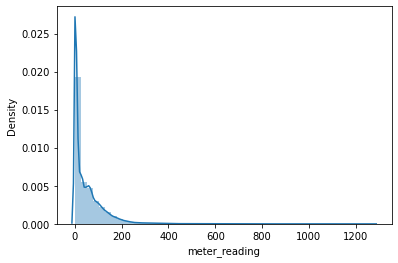

In [163]:
sns.distplot(submission_meter_3['meter_reading'])

#### Concatenate all predicted datasets

In [164]:
concat_df = [submission_meter_0, submission_meter_1, submission_meter_2, submission_meter_3]

kaggle_test_df = pd.concat(concat_df, axis=0)

In [165]:
kaggle_test_df.shape

(41697600, 30)

In [166]:
test_df.shape

(41697600, 29)

In [167]:
kaggle_submission = kaggle_test_df[['row_id','meter_reading']]

In [168]:
kaggle_submission = kaggle_submission.sort_values(by='row_id')

In [170]:
kaggle_submission.to_csv('s3://jiashengs3/kaggle_submission(gru).csv', index=False)

## Models Ensembling

The goal of employing ensemble models is to lower the prediction's generalization error.

Best kaggle score with 0.9 weights for LGBM model prediction + 0.1 weights for GRU model

In [5]:
obj2 = s3.Bucket('jiashengs3').Object('kaggle_submission(lgbm).csv').get()
obj3 = s3.Bucket('jiashengs3').Object('kaggle_submission(gru).csv').get()

In [6]:
# retriving prediction from lgbm and gru models
lgbm_model = pd.read_csv(obj2['Body'],index_col=0)
gru_model = pd.read_csv(obj3['Body'],index_col=0)

In [7]:
merged_model = lgbm_model.merge(gru_model, on=('row_id')).reset_index()

In [11]:
def ensemble_ratio(df, ratio_lgbm):
    
    df['meter_reading'] = df['meter_reading_x'] * ratio_lgbm + df['meter_reading_y'] * (1-ratio_lgbm)
    df = df.drop(columns=['meter_reading_x','meter_reading_y'])
    
    return df

In [12]:
ensembled_df = ensemble_ratio(merged_model,0.9)

In [15]:
ensembled_model = reduce_mem_usage(ensembled_df)

Memory usage of dataframe is 636.26 MB
Memory usage after optimization is: 318.13 MB
Decreased by 50.0%


In [17]:
ensembled_model.to_csv('s3://jiashengs3/ensembled_model.csv', index=False)

## Significant Findings and Recommendations

**General Findings from EDA**

- There are nearly the same number of normalized observations in the testing dataset VS training dataset, indicating that the variance for the various features is well-represented.

- Building 1099 is a clear anomaly. Given its GFA, the building is unlikely to consume so much energy. It's possible that the meters aren't working properly or that the meter readings are cumulative.

- Education and facilities consume the most energy. When classified by site, site 13 spends the most energy (because to building 1099), and when sorted by meter type, meter 2 consumes the most energy (also because of building 1099).

- From 2016 to 2018, we continuously find increased usage throughout the summer (June-Sept) and winter (December-March) seasons based on the Average Air-Temperature VS Meter Reading. The fact that heaters are typically used when temperatures are cold and air conditioners are used when temperatures are hot helps explain this tendency. Both of these factors contribute to increased energy use.

- Using LOFO analysis, the top features in all four meter kinds are square feet, building id, primary use, and building counts per site.

**Significant Findings**:

- In the setting of a large dataset, decision tree ensemble models such as Light Gradient Boosting Trees are an effective and efficient model type for time-series hourly energy regression. Complex models, such as deep learning GRU, are less effective when used alone (especially with missing time sequences), but they can be combined with other models to produce better predictions with smaller generalization errors.

- In this project, we used ensemble models of Light Gradient Boost and Deep Learning GRU in our project to attain a respectable RMSLE score of 1.191 (public board) in the kaggle competition without using any leaked data. When compared to individual model scores, the kaggle score produced from ensemble models is superior.

- Another important discovery was that all machine learning process steps had an effect on model accuracy, as seen in the following examples:

    - With some domain expertise in meters and simple intuition, abnormal readings for the four meters were detected and dropped

    - Additional weather parameters like feels like temperature, wind chill, and heat index have a favorable impact on the model and are acknowledged as key elements in our LOFO analysis.

**Recommendations**
- Developing one model for each building (1449 models in total)
- Developing one model for each site (16 models in total)
- One hot encode building_id and site_id before modeling (computationally expensive)
- Experiment relations of existing features and target variable (prediciting kwh/ft2 instead) 